### Mean-Variance Potfolio Optimization with Elastic Net Penalty

TO-DO
- Compare OOS performance of split-bregman using normal params and regularized params
- Compare OOS performance of optimal split bregman against mean variance optimal; equally weighted 
- Grid search multiple penalty values

In [3]:
import itertools
import numpy as np
import pandas as pd
import scipy.optimize
from qpsolvers import solve_qp
from scipy.sparse import csc_matrix, csc_array
import matplotlib.pyplot as plt

###  Returns below
- Note log returns have caused some issues numerically within optimiztion

In [290]:
equity_data=pd.read_csv('equity_data_2010_2020.csv')
equity_data.index=equity_data['Date']
equity_data=equity_data.drop(columns=['Date'])
equity_data=equity_data[equity_data.columns[:100]]

returns=(equity_data/equity_data.shift(1))-1
returns=returns.fillna(0)
returns=returns.iloc[1:]
frac=0.5
cutoff=np.floor(frac*len(returns.index)).astype(int)

returns_train=returns.iloc[:cutoff]
returns_test=returns.iloc[cutoff:]

returns_train

,MMM,AOS,ABT,ABBV,ABMD,ACN,ATVI,ADM,ADBE,ADP,...,CAT,CBOE,CBRE,CDW,CE,CNC,CNP,CDAY,CF,CRL
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-05,-0.006264,-0.012777,-0.008079,0.000000,-0.024027,0.006180,0.001770,0.005402,0.016446,-0.005370,...,0.011956,0.000000,0.023878,0.000000,0.022249,-0.031797,-0.007576,0.0,0.016224,0.005660
2010-01-06,0.014182,0.000454,0.005553,0.000000,-0.015240,0.010631,-0.005300,-0.002528,-0.002122,-0.002347,...,0.003038,0.000000,-0.008481,0.000000,0.010882,0.011899,-0.009715,0.0,0.041680,-0.013329
2010-01-07,0.000717,0.002951,0.008284,0.000000,0.000000,-0.000935,-0.023979,-0.010456,-0.019405,-0.000471,...,0.004038,0.000000,0.009979,0.000000,0.005237,0.024929,0.009811,0.0,-0.010080,0.039327
2010-01-08,0.007046,0.014709,0.005112,0.000000,-0.020238,-0.003978,-0.008189,-0.012488,-0.005422,-0.001413,...,0.011228,0.000000,0.002117,0.000000,-0.009262,-0.010096,-0.011797,0.0,0.021509,-0.006644
2010-01-11,-0.004032,-0.004683,0.005086,0.000000,-0.018226,-0.000940,-0.000917,0.000649,-0.013083,0.004479,...,0.062811,0.000000,-0.009859,0.000000,0.002921,-0.007881,0.007022,0.0,-0.001119,0.010177
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-12-24,0.000539,0.003035,-0.000437,0.028904,0.003392,-0.001094,0.005932,-0.001128,0.004840,0.000822,...,0.002353,-0.002473,-0.001715,0.003931,0.001994,0.009816,0.013220,0.0,-0.011340,0.005217
2014-12-26,-0.004193,0.007653,0.003282,0.011630,0.004680,-0.000657,0.003440,0.005837,-0.000937,-0.000469,...,0.005442,-0.005269,0.001145,0.004755,0.002985,0.000661,0.007155,0.0,-0.003194,0.011008
2014-12-29,0.002707,0.000883,-0.005453,0.002389,-0.004141,-0.008109,-0.002938,-0.005429,-0.007232,-0.003873,...,-0.005518,0.006231,0.002574,-0.005289,0.001818,-0.006130,0.015044,0.0,-0.006227,0.002333


### Computation of Naive mean and covariance estimation from sample

In [291]:
returns_mean=returns_train.mean().values
returns_cov=np.cov(returns_train.T)

Text(0, 0.5, 'Freq')

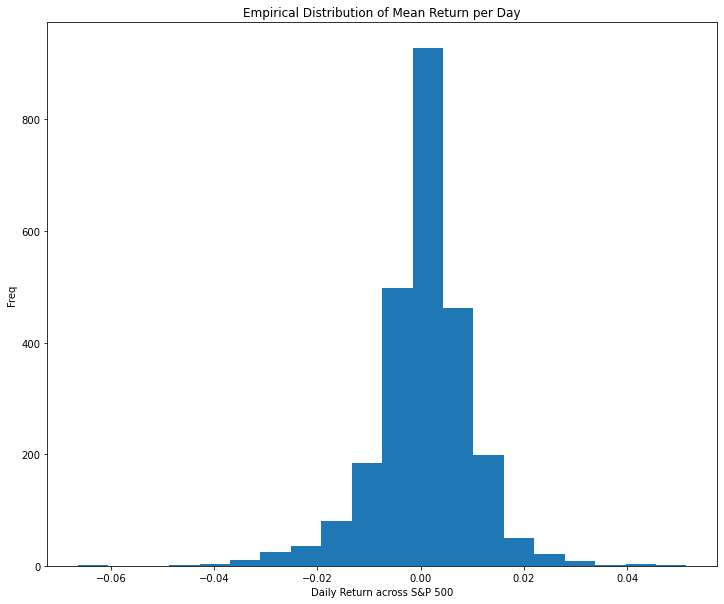

In [292]:
fig,ax=plt.subplots(figsize=(12,10))
bins=plt.hist(returns.mean(axis=1),bins=20)
plt.title("Empirical Distribution of Mean Return per Day")
plt.xlabel("Daily Return across S&P 500")
plt.ylabel("Freq")

Text(0.5, 1.0, 'Singular Values of Covariance Matrix')

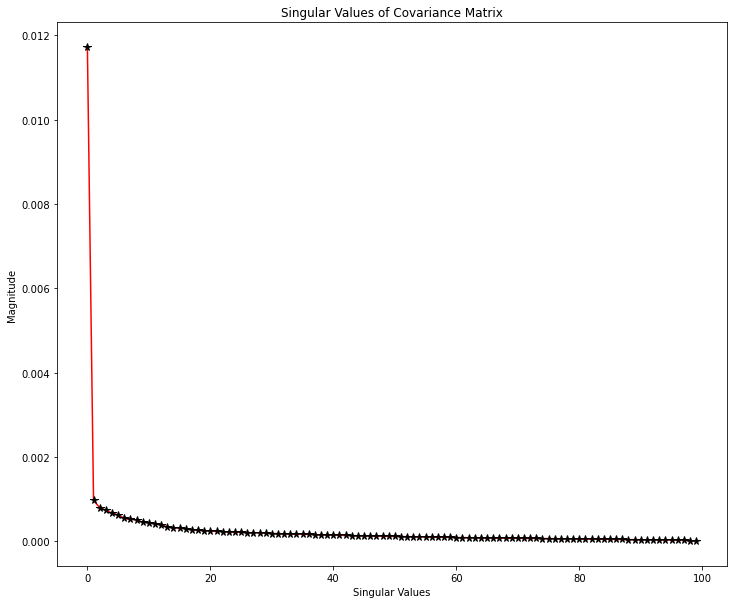

In [293]:
u,s,v=np.linalg.svd(returns_cov)
fig,ax=plt.subplots(figsize=(12,10))
bins=plt.plot(s,marker='*',color='red',markersize=7.5,mfc='black',mec='black')
plt.xlabel('Singular Values')
plt.ylabel('Magnitude')
plt.title("Singular Values of Covariance Matrix")

### Regularized Mean and Covariance Estimators 

In [294]:
def james_stein(mu):
    pass


def reg_cov(cov):
    pass

### Application of Sparse Solver Split Bregman Operator

Utilizes nested optimization routine where
- Inner Optimization is unconstrained QP problem involving L2 penalty
    - Can solve numerically via unconstrained minimization
    - Solve analytically via QPSolvers
- Applies shrinkage (L1) penalty within outer loop


In [372]:
def qp(cov,mean,w,d,b,beta,lambda2,tol,maxiter,approach):
    """ Inner optimization problem using unconstrained optimization 
        Approach 1 solves numerically via unconstrained minimization
        Approach 2 solves analytically via qpsolvers; reformulates penalty
    """
    
    x0=w # initial guess is previous result
    
    if approach==1:
        # Numerical soln is much slower as unconstrained minimization
        def objective_val(w,cov,mean,d,b,beta,lambda2):
            """ MPT objective
            """

            obj=np.dot(np.dot(w,cov),w)-np.dot(w,mean)

            l2_pen=np.sum((d-beta*w-b)**2)

            return obj+lambda2*l2_pen/2

        res=scipy.optimize.minimize(objective_val,x0=w,args=(returns_cov,returns_mean,d,b,beta,lambda2),method='CG',options={'maxiter':25},tol=1e-12)
        w=res.x
        
    if approach==2:
        # analytical soln is very fast; incorporates the penalty term in linear term
        
        w_old=w
        quad=csc_matrix(2*(cov+2*lambda2*np.identity(len(mean))))
        linear=-1*mean+lambda2*(-d+b)/2
        w = solve_qp(quad,linear,initvals=x0, solver="osqp")
        
        if w is None:
            return w_old
        
    return w

def shrinkage(w,d,b,lambda1,beta):
    """ Shrinkage operator; second optimization routine
    """
    
    x=beta*w-b
    
    obj=np.fmax([np.abs(x)-(1/lambda1)],[np.zeros(len(w))])  # elementwise max
    signed_obj=np.sign(x)*obj
    
    return signed_obj[0]

def split_bregman(cov,mean,lambda1,lambda2,beta=None,tol=1e-10,maxiter=100,approach=2):
    """ Split Bregman Optimization Routine
    """

    error=1
    n=len(mean)
    if beta is None:
        beta=np.ones(n)
    
    b=np.zeros(n)
    w=np.zeros(n)
    d=np.zeros(n)
    
    
    i=0
    while error>tol:
        if i>maxiter:
            print("MaxIter Achieved")
            break
            
        
        if i%25==0 and i>0:
            print(f"{i}-th iteration with error of {error}")
        
        w=qp(cov,mean,w,d,b,beta,lambda2,tol,maxiter,approach)
        
        d=shrinkage(w,d,b,lambda1,beta)
        b=b+beta*w-d  
    
        i+=1
        
        # adapt error tol for better results
       # error=np.sum((w-w_old)**2)
        error=abs(np.dot(np.dot(w,cov),w)-np.dot(w.T,mean)+np.sum(abs(w))+np.sum(w**2))
    
    
    print(f"Terminated in {i} iterations of error {error} for lambda1={lambda1} and lambda2={lambda2}")
    unit_w=w/np.linalg.norm(w,ord=1)
    return unit_w, error



### Numerical Results

- Grid search both lambda values
- Doesn't seem sparsity makes a difference (further investigation)

In [373]:
lambda1=10e-3

lambda2=0
w0,error1=split_bregman(returns_cov,returns_mean,lambda1=lambda1,lambda2=lambda2,tol=1e-8,maxiter=100,approach=2)

25-th iteration with error of 502.4397379093496
50-th iteration with error of 502.43973790934945
75-th iteration with error of 502.4397379093496
100-th iteration with error of 502.43973790934945
MaxIter Achieved
Terminated in 101 iterations of error 502.4397379093496 for lambda1=0.01 and lambda2=0


Text(0, 0.5, 'Weight Allocation')

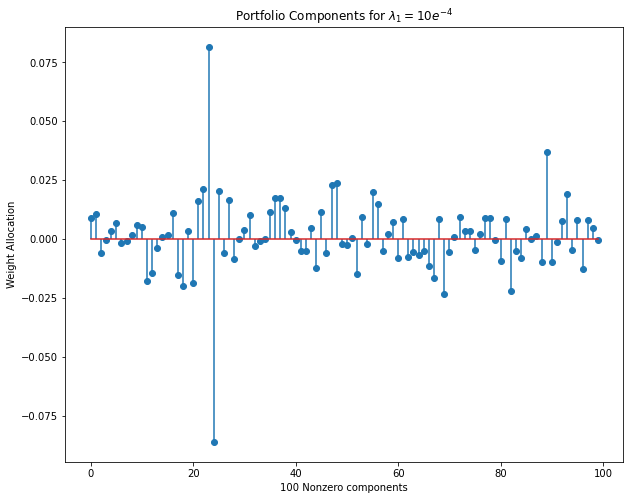

In [367]:
nonzero_w0=np.where(abs(w0)>0)[0]

fig,ax=plt.subplots(figsize=(10,8))
plt.title("Portfolio Components for $\lambda_1=10e^{-4}$")
ax.stem(nonzero_w0,w0[nonzero_w0])
plt.xlabel(f"{len(nonzero_w0)} Nonzero components")
plt.ylabel("Weight Allocation")

In [359]:
lambda1=10e-1
lambda2=0
w1,error1=split_bregman(returns_cov,returns_mean,lambda1=lambda1,lambda2=lambda2,tol=1e-8,maxiter=25,approach=2)

25-th iteration with error of 504.4397379093496
MaxIter Achieved
Terminated in 26 iterations of error 504.43973790934945 for lambda1=1.0 and lambda2=0


Text(0, 0.5, 'Weight Allocation')

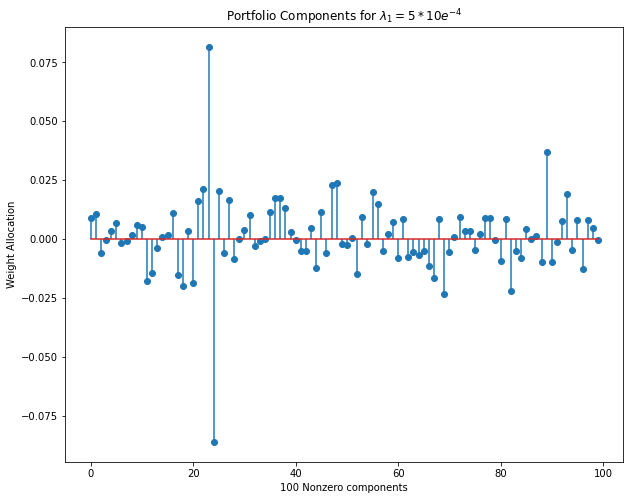

In [360]:
nonzero_w1=np.where(abs(w1)>0)[0]

fig,ax=plt.subplots(figsize=(10,8))
plt.title("Portfolio Components for $\lambda_1=5*10e^{-4}$")
ax.stem(nonzero_w1,w1[nonzero_w1])
plt.xlabel(f"{len(nonzero_w1)} Nonzero components")
plt.ylabel("Weight Allocation")

In [361]:
lambda1=10
lambda2=0
w2,error2=split_bregman(returns_cov,returns_mean,lambda1=lambda1,lambda2=lambda2,tol=1e-8,maxiter=25,approach=2)

25-th iteration with error of 504.4397379093496
MaxIter Achieved
Terminated in 26 iterations of error 504.43973790934945 for lambda1=10 and lambda2=0


Text(0, 0.5, 'Weight Allocation')

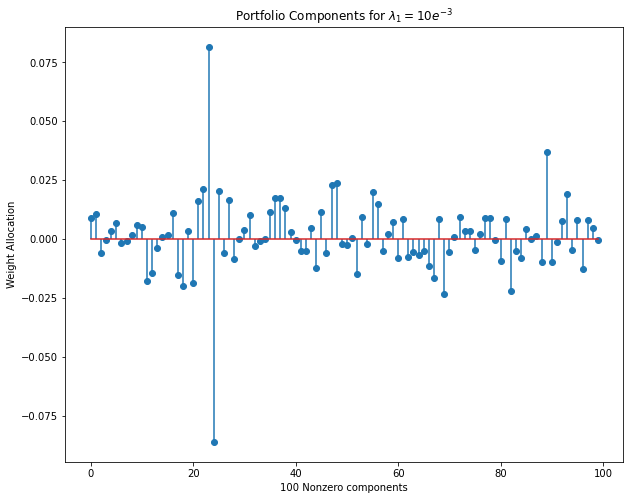

In [362]:
nonzero_w2=np.where(abs(w2)>0)[0]

fig,ax=plt.subplots(figsize=(10,8))
plt.title("Portfolio Components for $\lambda_1=10e^{-3}$")
ax.stem(nonzero_w2,w2[nonzero_w2])
plt.xlabel(f"{len(nonzero_w2)} Nonzero components")
plt.ylabel("Weight Allocation")


In [363]:
lambda1=10e3
lambda2=0
w3,error3=split_bregman(returns_cov,returns_mean,lambda1=lambda1,lambda2=lambda2,tol=1e-8,maxiter=25,approach=2)

25-th iteration with error of 504.4397379093496
MaxIter Achieved
Terminated in 26 iterations of error 504.43973790934945 for lambda1=10000.0 and lambda2=0


Text(0, 0.5, 'Weight Allocation')

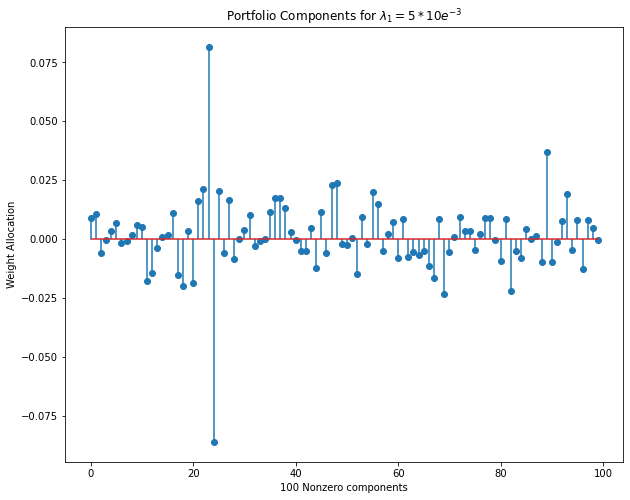

In [364]:
nonzero_w3=np.where(abs(w3)>0)[0]

fig,ax=plt.subplots(figsize=(10,8))
plt.title("Portfolio Components for $\lambda_1=5*10e^{-3}$")
ax.stem(nonzero_w3,w3[nonzero_w3])
plt.xlabel(f"{len(nonzero_w3)} Nonzero components")
plt.ylabel("Weight Allocation")

### Grid Search Lambda Values 
- Cross valaidate optimal $\lambda_1$ and $\lambda_2$ parameters representing L1 and L2 regularization

In [330]:
def grid_search(params,returns_mean,returns_cov,tol=1e-8,maxiter=25):
    results={}
    for i in params:
        lambda1,lambda2=i
        w,error=split_bregman(returns_cov,returns_mean,lambda1,lambda2,tol=1e-8,maxiter=25,approach=2)
        results[i]=(w,error)
    sorted_dict=sorted(results.items(), key=lambda x:x[1][1])
    return sorted_dict

lambda1_grid=np.logspace(-8,8,20)
lambda2_grid=[0]

params=[]
for i in itertools.product(lambda1_grid,lambda2_grid):
    params.append(i)

sorted_dict=grid_search(params,returns_mean,returns_cov)

25-th iteration with error of 502.4397379093496
MaxIter Achieved
Terminated in 26 iterations of error 502.43973790934945 for lambda1=1e-08 and lambda2=0
25-th iteration with error of 502.4397379093496
MaxIter Achieved
Terminated in 26 iterations of error 502.43973790934945 for lambda1=6.951927961775605e-08 and lambda2=0
25-th iteration with error of 502.4397379093496
MaxIter Achieved
Terminated in 26 iterations of error 502.43973790934945 for lambda1=4.832930238571752e-07 and lambda2=0
25-th iteration with error of 502.4397379093496
MaxIter Achieved
Terminated in 26 iterations of error 502.43973790934945 for lambda1=3.359818286283781e-06 and lambda2=0
25-th iteration with error of 502.4397379093496
MaxIter Achieved
Terminated in 26 iterations of error 502.43973790934945 for lambda1=2.3357214690901213e-05 and lambda2=0
25-th iteration with error of 502.4397379093496
MaxIter Achieved
Terminated in 26 iterations of error 502.43973790934945 for lambda1=0.0001623776739188721 and lambda2=0
2

Text(0, 0.5, 'Weight Allocation')

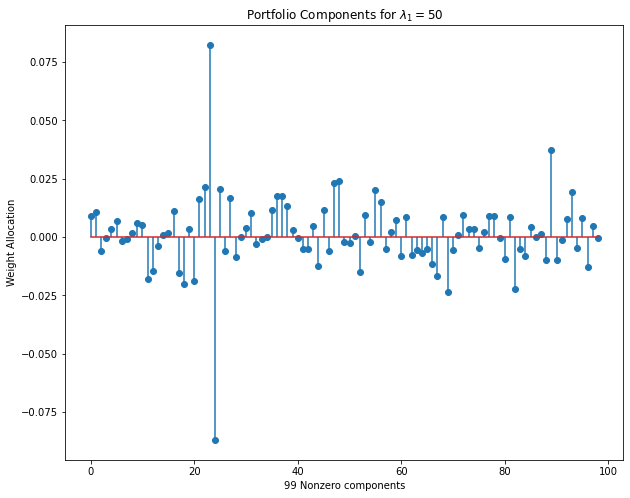

In [331]:
wi=sorted_dict[0][1][0]
nonzero_wi=np.where(abs(wi)>0)[0]

fig,ax=plt.subplots(figsize=(10,8))
plt.title("Portfolio Components for $\lambda_1=50$")
ax.stem(wi[nonzero_wi])
plt.xlabel(f"{len(wi[nonzero_wi])} Nonzero components")
plt.ylabel("Weight Allocation")

In [288]:
print(f"Largest Component is {max(abs(wi[nonzero_wi]))}")
print(f"Smallest Component is {min(abs(wi[nonzero_wi]))}")

Largest Component is 0.032383231659619746
Smallest Component is 9.755854686904761e-05


### Evaluation Criteria

In [31]:
returns_test

,MMM,AOS,ABT,ABBV,ABMD,ACN,ATVI,ADM,ADBE,ADP,...,WTW,GWW,WYNN,XEL,XYL,YUM,ZBRA,ZBH,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-02,-0.001582,-0.007091,-0.002665,0.006876,-0.019706,-0.005263,-0.000993,0.000385,-0.004952,-0.000960,...,-0.005802,0.001295,-0.012571,0.005568,0.000263,-0.006863,0.000258,-0.007318,-0.007717,0.006507
2015-01-05,-0.022553,-0.017497,0.000223,-0.018819,-0.006433,-0.016884,-0.013910,-0.034602,-0.004976,-0.000720,...,-0.007183,-0.024450,-0.017020,-0.011351,-0.062237,-0.020318,-0.014077,0.037304,-0.037469,-0.006003
2015-01-06,-0.010664,-0.008177,-0.011356,-0.004950,-0.025357,-0.007213,-0.018640,-0.019713,-0.020145,-0.008290,...,-0.004974,-0.014178,-0.021331,0.005321,-0.005881,-0.012274,-0.007205,-0.008477,-0.038193,-0.009756
2015-01-07,0.007249,0.007329,0.008108,0.040417,0.031829,0.020990,-0.021561,0.015032,0.008223,0.008723,...,0.014315,0.000896,0.029368,0.008635,0.007887,0.033138,0.025465,0.024870,0.009546,0.020643
2015-01-08,0.023967,0.026009,0.020554,0.010459,0.045064,0.015249,0.009969,-0.014609,0.025453,0.022940,...,0.011425,0.022266,0.012031,0.011599,0.007546,0.017420,0.021359,0.010617,0.013994,0.015399
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-24,-0.010030,0.007637,-0.000801,-0.004432,0.010913,0.003700,-0.001358,0.001304,0.002098,-0.000647,...,0.002034,-0.001007,-0.005634,-0.002539,-0.003927,0.005210,-0.009348,-0.002446,0.003701,0.004155
2019-12-26,-0.000509,0.005053,0.000000,-0.000223,-0.007487,0.002079,0.001360,0.002604,0.004732,0.002590,...,0.000149,0.004535,0.010757,-0.001114,-0.000509,0.014552,0.000354,-0.003778,0.002523,0.000828
2019-12-27,0.003794,0.001466,0.001375,-0.007013,-0.010175,0.000802,0.005094,0.002164,-0.001238,0.002466,...,-0.001287,-0.004249,-0.008018,0.005256,0.003053,0.001081,0.006210,-0.001929,-0.003097,0.001654


In [32]:
def get_sharpe(port_returns,rf=0.0178):
    sd=np.std(port_returns)*np.sqrt(252)
    mu=np.mean(port_returns)*252
    
    sharpe=(mu-rf)/sd
    
    return sharpe

### Optimally tuned penalty compared to equal weighted 

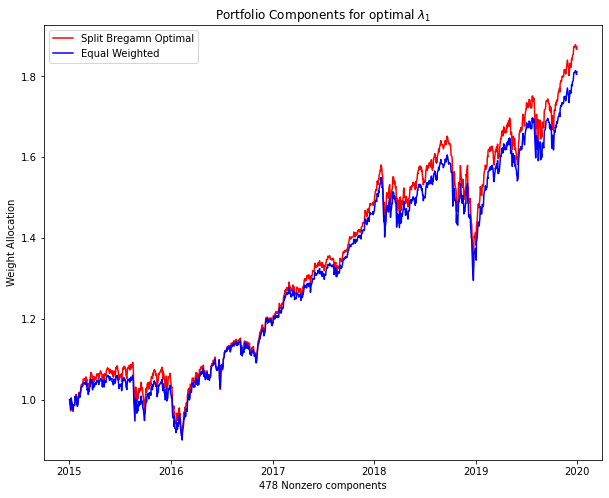

In [33]:
cum_returns_split_i=np.cumprod(1+np.dot(wi,returns_test.T))

equal=(1/returns_test.shape[1])*np.ones(returns_test.shape[1])
cum_returns_equal=np.cumprod(1+np.dot(equal,returns_test.T))
fig,ax=plt.subplots(figsize=(10,8))
plt.title("Portfolio Components for optimal $\lambda_1$")
plt.plot(pd.to_datetime(returns_test.index),cum_returns_split_i,label='Split Bregamn Optimal',color='red')
plt.plot(pd.to_datetime(returns_test.index),cum_returns_equal,label='Equal Weighted',color='blue')
plt.xlabel(f"{len(wi[nonzero_wi])} Nonzero components")
plt.ylabel("Weight Allocation")
plt.legend()


In [34]:
print(f"Sharpe of equal allocation is {round(get_sharpe(np.dot(equal,returns_test.T)),2)}")
print(f"Sharpe of Split-Bregman allocation is {round(get_sharpe(np.dot(wi,returns_test.T)),2)}")

Sharpe of equal allocation is 0.83
Sharpe of Split-Bregman allocation is 0.85


### Varying levels of lambda penalization 

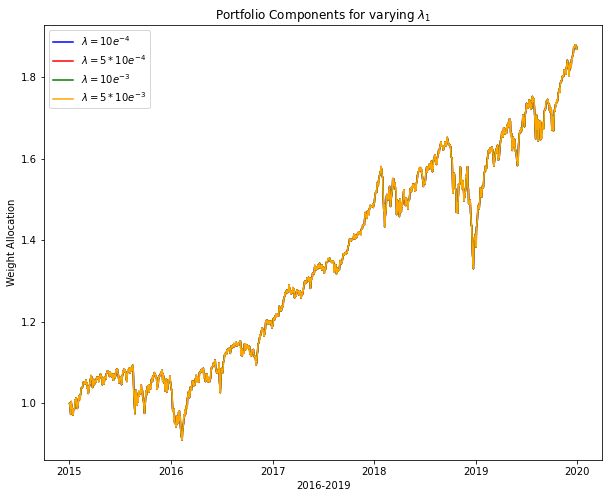

In [35]:
cum_returns_split_0=np.cumprod(1+np.dot(w0,returns_test.T))
cum_returns_split_1=np.cumprod(1+np.dot(w1,returns_test.T))
cum_returns_split_2=np.cumprod(1+np.dot(w2,returns_test.T))
cum_returns_split_3=np.cumprod(1+np.dot(w3,returns_test.T))

fig,ax=plt.subplots(figsize=(10,8))
plt.title("Portfolio Components for varying $\lambda_1$")
plt.plot(pd.to_datetime(returns_test.index),cum_returns_split_0,label='$\lambda=10e^{-4}$',color='blue')
plt.plot(pd.to_datetime(returns_test.index),cum_returns_split_1,label='$\lambda=5*10e^{-4}$',color='red')
plt.plot(pd.to_datetime(returns_test.index),cum_returns_split_2,label='$\lambda=10e^{-3}$',color='green')
plt.plot(pd.to_datetime(returns_test.index),cum_returns_split_3,label='$\lambda=5*10e^{-3}$',color='orange')
plt.xlabel("2016-2019")
plt.ylabel("Weight Allocation")
plt.legend()

